import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the data
train_tx = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\train_tx_data.npy')
train_rx = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\train_rx_noisy_data.npy')
test_tx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_tx_data.npy')
test_rx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_rx_noisy_data.npy')

# Reshape the data
train_rx = train_rx.reshape(-1, 1, 8)
train_tx= train_tx.reshape(-1, 1, 8)
test_rx = test_rx.reshape(-1, 1, 8)
test_tx = test_tx.reshape(-1, 1, 8)


# Scaling function
def scale_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Scale the data
train_tx_scaled = scale_data(train_tx)
train_rx_scaled = scale_data(train_rx)
test_tx_scaled = scale_data(test_tx)
test_rx_scaled = scale_data(test_rx)

# Check shapes
(train_rx_scaled.shape, train_tx_scaled.shape, test_rx_scaled.shape, test_tx_scaled.shape)


## bigru

In [3]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Bidirectional, GRU, Dense, TimeDistributed, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define the Bi-GRU model with multiple layers
# bigru_model = Sequential([
#     Bidirectional(GRU(128, activation='tanh', return_sequences=True), input_shape=(1, 8)),  # First Bi-GRU layer
#     Dropout(0.2),  # Dropout for regularization
#     Bidirectional(GRU(128, activation='tanh', return_sequences=True)),  # Second Bi-GRU layer
#     Dropout(0.2),  # Dropout for regularization
#     Bidirectional(GRU(64, activation='tanh', return_sequences=True)),   # Third Bi-GRU layer
#     Dropout(0.2),  # Dropout for regularization
#     TimeDistributed(Dense(64, activation='relu')),       # Fully connected layer
#     TimeDistributed(Dense(8, activation='linear'))       # Output layer to match (8, 8)
# ])

# # Compile the model
# bigru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# # Model summary
# bigru_model.summary()
# # Train the model
# history = bigru_model.fit(
#     train_rx_scaled , train_tx_scaled ,
#     validation_data=(test_rx_scaled , test_tx_scaled ),
#     epochs=50,
#     batch_size=64,
#     verbose=1
# )

# # Evaluate the model
# test_loss, test_mae = bigru_model.evaluate(test_rx_scaled, test_tx_scaled, verbose=0)
# print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# # Predict on test data
# predicted_tx = bigru_model.predict(test_rx_scaled)

# # Save the model
# bigru_model.save("bigru_signal_prediction_model.h5")

# # Visualization of results
# import matplotlib.pyplot as plt

# # Plot actual vs predicted for a random sample
# idx = np.random.randint(2, len(test_tx_scaled))
# plt.figure(figsize=(10, 6))
# plt.plot(test_tx_scaled[idx].flatten(), label='Actual TX Signal', alpha=0.7)
# plt.plot(predicted_tx[idx].flatten(), label='Predicted TX Signal', alpha=0.7)
# plt.plot(test_rx_scaled[idx].flatten(), label='test RX Signal', alpha=0.7)
# plt.legend()
# plt.title('Actual vs Predicted TX Signal')
# plt.show()

## bilstm

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 128)           37376     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 128)           98816     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 1, 8)             1032      
 ibuted)                                                         
                                                                 
Total params: 137,224
Trainable params: 137,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4773/4773 [==============================] - 60s 11ms/step - loss: 0.0359 - mae: 0.1439 - val_loss: 0.01

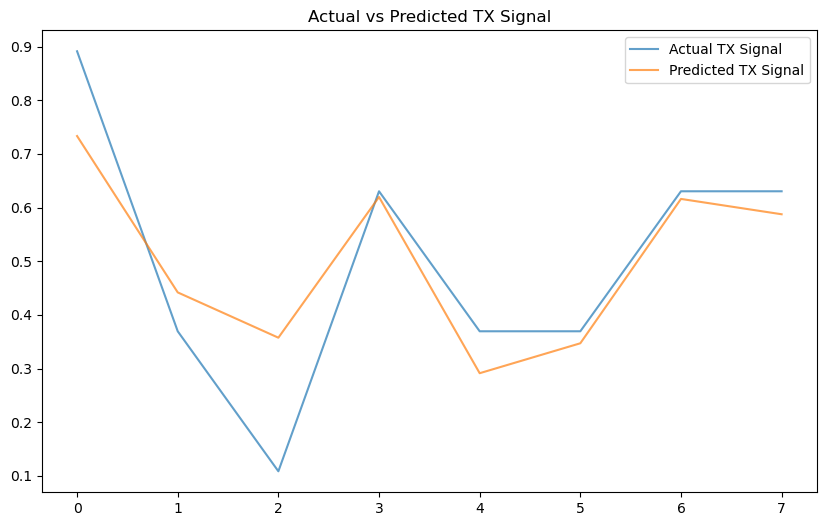

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Define the BiLSTM model
bi_model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(1, 8)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    TimeDistributed(Dense(8, activation='linear'))  # Output shape matches (1, 8)
])

# Compile the model
bi_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model summary
bi_model.summary()

# Train the model
history = bi_model.fit(
    train_rx_scaled , train_tx_scaled ,
    validation_data=(test_rx_scaled , test_tx_scaled ),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = bi_model.evaluate(test_rx_scaled, test_tx_scaled, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict on test data
predicted_tx = bi_model.predict(test_rx_scaled)

# Save the model
bi_model.save("bi_lstm_signal_prediction_model.h5")

# Visualization of results
import matplotlib.pyplot as plt

# Plot actual vs predicted for a random sample
idx = np.random.randint(0, len(test_tx_scaled))
plt.figure(figsize=(10, 6))
plt.plot(test_tx_scaled[idx].flatten(), label='Actual TX Signal', alpha=0.7)
plt.plot(predicted_tx[idx].flatten(), label='Predicted TX Signal', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted TX Signal')
plt.show()

## U-Net, ResNet starts from here

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the data
train_tx = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\train_tx_data.npy')
train_rx = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\train_rx_noisy_data.npy')
test_tx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_tx_data.npy')
test_rx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_rx_noisy_data.npy')

# Reshape the data
train_rx = train_rx.reshape(-1, 1, 8, 1)
train_tx= train_tx.reshape(-1, 1, 8, 1)
test_rx = test_rx.reshape(-1, 1, 8, 1)
test_tx = test_tx.reshape(-1, 1, 8, 1)


# Scaling function
def scale_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Scale the data
train_tx_scaled = scale_data(train_tx)
train_rx_scaled = scale_data(train_rx)
test_tx_scaled = scale_data(test_tx)
test_rx_scaled = scale_data(test_rx)

# Check shapes
(train_rx_scaled.shape, train_tx_scaled.shape, test_rx_scaled.shape, test_tx_scaled.shape)


((305440, 1, 8, 1), (305440, 1, 8, 1), (30048, 1, 8, 1), (30048, 1, 8, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 8, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 8, 64)     640         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1, 8, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 8, 64)     36928       ['dropout[0][0]']                
                                                                                              

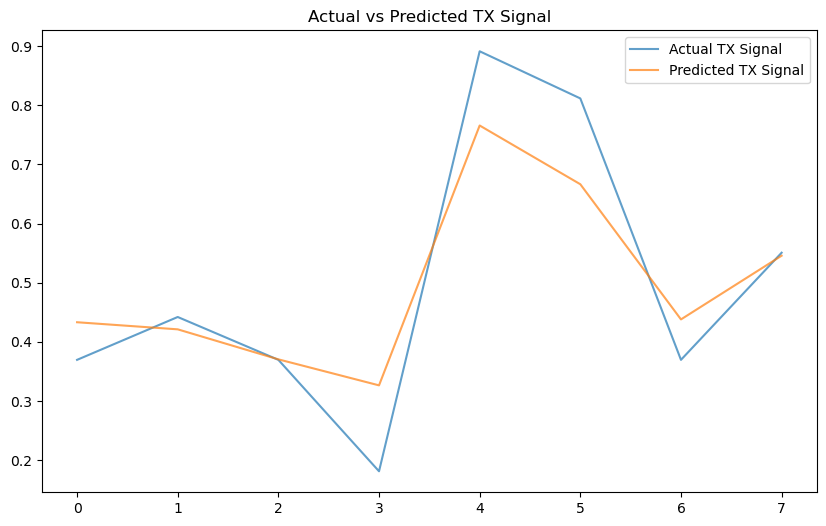

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(1, 2))(conv1)  # Adjust pooling

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(1, 2))(conv2)  # Adjust pooling

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(1, 2))(conv3)  # Adjust pooling

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(1, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(1, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(1, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='linear')(conv7)

    return Model(inputs, outputs)


# Input shape (8, 8, 1) for 2D input (e.g., spatial data)
input_shape = (1, 8, 1)
unet_model = build_unet(input_shape)

# Compile the model
unet_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model summary
unet_model.summary()

# Train the model
history = unet_model.fit(
    train_rx_scaled , train_tx_scaled ,
    validation_data=(test_rx_scaled , test_tx_scaled ),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = unet_model.evaluate(test_rx_scaled, test_tx_scaled, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict on test data
predicted_tx = unet_model.predict(test_rx_scaled)

# Save the model
unet_model.save("unet_signal_prediction_model.h5")

# Visualization of results
import matplotlib.pyplot as plt

# Plot actual vs predicted for a random sample
idx = np.random.randint(0, len(test_tx_scaled))
plt.figure(figsize=(10, 6))
plt.plot(test_tx_scaled[idx].flatten(), label='Actual TX Signal', alpha=0.7)
plt.plot(predicted_tx[idx].flatten(), label='Predicted TX Signal', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted TX Signal')
plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 8, 1)]    0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 1, 8, 64)     640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 8, 64)    256         ['conv2d_15[0][0]']              
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 1, 8, 64)     0           ['batch_normalization[0][0]

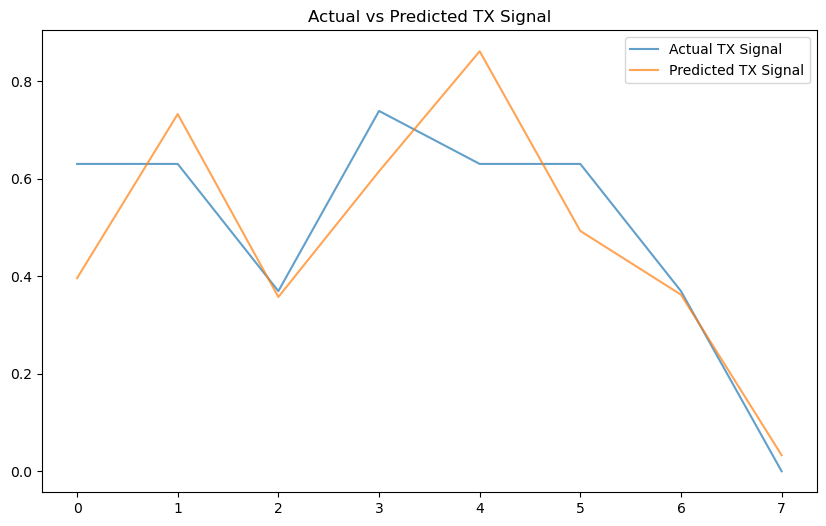

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add

def residual_block(x, filters, kernel_size=3):
    """Defines a residual block with two convolutional layers."""
    shortcut = x  # Save the input for the residual connection

    # First convolution
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = BatchNormalization()(x)

    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_res_blocks=3):
    """Builds a ResNet model with same input and output dimensions."""
    inputs = Input(shape=input_shape)

    # Initial convolution layer
    x = Conv2D(64, kernel_size=3, padding='same', activation=None)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Add residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, filters=64)

    # Final output layer to match input shape
    outputs = Conv2D(input_shape[-1], kernel_size=1, activation='linear', padding='same')(x)

    return Model(inputs, outputs)

# Define the model
input_shape = (1, 8, 1)  # Input is a 2D signal with 1 channel
resnet_model = build_resnet(input_shape, num_res_blocks=5)

# Compile the model
resnet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
resnet_model.summary()


# Train the model
history = resnet_model.fit(
    train_rx_scaled , train_tx_scaled ,
    validation_data=(test_rx_scaled , test_tx_scaled ),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = resnet_model.evaluate(test_rx_scaled, test_tx_scaled, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict on test data
predicted_tx = resnet_model.predict(test_rx_scaled)

# Save the model
resnet_model.save("resnet_signal_prediction_model.h5")

# Visualization of results
import matplotlib.pyplot as plt

# Plot actual vs predicted for a random sample
idx = np.random.randint(0, len(test_tx_scaled))
plt.figure(figsize=(10, 6))
plt.plot(test_tx_scaled[idx].flatten(), label='Actual TX Signal', alpha=0.7)
plt.plot(predicted_tx[idx].flatten(), label='Predicted TX Signal', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted TX Signal')
plt.show()

## Verify unet and resnet model

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the data
test_tx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_tx_data.npy')

# Reshape the data
test_tx = test_tx.reshape(-1, 1, 8, 1)
test_rx  = np.load(fr'F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\Datasets\test_rx_noisy_data.npy')

# Reshape the data
test_rx = test_rx.reshape(-1, 1, 8, 1)

# Scaling function
def scale_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Scale the data
test_tx_scaled1 = scale_data(test_tx)
test_rx_scaled1 = scale_data(test_rx)

print("shape os test tx scaled1",test_tx_scaled1.shape)
print("shape os test rx scaled1",test_rx_scaled1.shape)

# Check shapes
(test_tx_scaled1.shape, test_rx_scaled1.shape)

# test_tx = test_tx_scaled1[:32].reshape(-1)
# test_tx = ', '.join(map(str, test_tx))
# print(test_tx)


shape os test tx scaled1 (30048, 1, 8, 1)
shape os test rx scaled1 (30048, 1, 8, 1)


((30048, 1, 8, 1), (30048, 1, 8, 1))

## for donation paper

In [9]:
# import numpy as np
# from tensorflow.keras.models import load_model
# from sklearn.metrics import r2_score, mean_squared_error

# # File paths for saved models
# model_paths = [
#      "bigru_signal_prediction_model.h5",
#     "resnet_signal_prediction_model.h5",
#     "bi_lstm_signal_prediction_model.h5"
# ]

# # Load the models
# models = [load_model(path) for path in model_paths]

# # Predict using each model with appropriate input shape
# predictions = {}
# for model, path in zip(models, model_paths):
#     model_name = path.split('_')[0].capitalize()  # Extract model name from file path
    
#     # Reshape input based on model type
#     if model_name in [ "Resnet"]:
#         input_data = test_rx_scaled1.reshape(-1, 1, 8, 1)  # Shape for U-Net and ResNet
#     elif model_name in [ "Bigru","Bi"]:
#         input_data = test_rx_scaled1.reshape(-1, 1, 8)  # Shape for LSTM, GRU, BiLSTM
#     else:
#         raise ValueError(f"Unsupported model type: {model_name}")

#     # Predict
#     print(f"Model name: {model_name}")
#     predictions[model_name] = model.predict(input_data)

# # Display predictions for the first 16 samples
# for model_name, prediction_rx in predictions.items():
#     # predicted_tx = prediction[:320].reshape(-1)  # Flatten the first 16 predictions
#     # predicted_tx_str = ', '.join(map(str, predicted_tx))  # Convert to string for display
#     # print(f"{model_name} predictions (first 16):")
#     # print(predicted_tx_str)
#     # Ensure consistency in shapes
#     actual_tx = test_tx_scaled1.flatten()
#     predicted_tx = prediction_rx.flatten()
    
#     if actual_tx.shape[0] != predicted_tx.shape[0]:
#         raise ValueError(f"Shape mismatch between actual ({actual_tx.shape}) and predicted ({predicted_tx.shape}) data for {model_name}")
    
#     # Compute R² score
#     r2 = r2_score(actual_tx, predicted_tx)

#     # Compute Pearson Correlation Coefficient (PCC)
#     pcc = np.corrcoef(actual_tx, predicted_tx)[0, 1]

#     # Compute RMSE
#     rmse = np.sqrt(mean_squared_error(actual_tx, predicted_tx))

#     # Print the results
#     print(f"\nEvaluation for {model_name}:")
#     print(f"R² Score: {r2:.4f}")
#     print(f"Pearson Correlation Coefficient (PCC): {pcc:.4f}")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



## for my paper

In [15]:
import numpy as np
from tensorflow.keras.models import load_model

# File paths for saved models
model_paths = [
    "unet_signal_prediction_model.h5", 
    "resnet_signal_prediction_model.h5",
    "bilstm_signal_prediction_model.h5"
]

# Load the models
models = [load_model(path) for path in model_paths]

# Predict using each model with appropriate input shape
predictions = {}
for model, path in zip(models, model_paths):
    model_name = path.split('_')[0].capitalize()  # Extract model name from file path
    
    # Reshape input based on model type
    if model_name in ["Unet", "Resnet"]:
        input_data = test_rx_scaled1.reshape(-1, 1, 8, 1)  # Shape for U-Net and ResNet
    elif model_name in [ "Bilstm"]:
        input_data = test_rx_scaled1.reshape(-1, 1, 8)  # Shape for LSTM, GRU, BiLSTM
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Predict
    print(f"Model name: {model_name}")
    predictions[model_name] = model.predict(input_data)

# Display predictions for the first 16 samples
for model_name, prediction in predictions.items():
    predicted_tx = prediction[:320].reshape(-1)  # Flatten the first 16 predictions
    predicted_tx_str = ', '.join(map(str, predicted_tx))  # Convert to string for display
    print(f"{model_name} predictions (first 16):")
    print(predicted_tx_str)


Model name: Unet
939/939 [==============================] - 4s 4ms/step
Model name: Resnet
939/939 [==============================] - 4s 4ms/step
Model name: Bilstm
939/939 [==============================] - 5s 4ms/step
Unet predictions (first 16):
0.59923023, 0.48692977, 0.51207155, 0.66470194, 0.3167863, 0.37339833, 0.55393153, 0.47154063, 0.5798488, 0.5345664, 0.6327704, 0.44945028, 0.5395474, 0.52397025, 0.29502535, 0.4891802, 0.48800424, 0.43019706, 0.66988266, 0.78870153, 0.30003625, 0.39513978, 0.5496956, 0.45153803, 0.4431626, 0.47941744, 0.57975066, 0.33663604, 0.4607733, 0.7767052, 0.49497867, 0.4267049, 0.56325597, 0.39159474, 0.45868045, 0.65778184, 0.3394119, 0.45062044, 0.5793321, 0.49161282, 0.5766002, 0.46390992, 0.5756743, 0.45203745, 0.6100541, 0.32690093, 0.2426972, 0.7247231, 0.5606495, 0.40859857, 0.6647097, 0.6002573, 0.47423387, 0.4906575, 0.29462665, 0.4855603, 0.5923039, 0.18745649, 0.43484467, 0.5493814, 0.6299215, 0.65762544, 0.36791015, 0.61178774, 0.6409873

In [17]:
import numpy as np
from tensorflow.keras.models import load_model

# File paths for saved models
model_paths = [
    "unet_signal_prediction_model.h5", # for my paper
    # "bigru_signal_prediction_model.h5",
    "resnet_signal_prediction_model.h5",
    "bilstm_signal_prediction_model.h5"
]

# Load the models
models = [load_model(path) for path in model_paths]

# Predict using each model with appropriate input shape
predictions = {}
for model, path in zip(models, model_paths):
    model_name = path.split('_')[0].capitalize()  # Extract model name from file path
    
    # Reshape input based on model type
    if model_name in ["Unet", "Resnet"]:
        input_data = test_rx_scaled1.reshape(-1, 1, 8, 1)  # Shape for U-Net and ResNet
    elif model_name in ["Lstm", "Bigru", "Bilstm"]:
        input_data = test_rx_scaled1.reshape(-1, 1, 8)  # Shape for LSTM, GRU, BiLSTM
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Predict
    print(f"Model name: {model_name}")
    predictions[model_name] = model.predict(input_data)

# Display predictions for the first 16 samples
for model_name, prediction in predictions.items():
    predicted_tx = prediction[:320].reshape(-1)  # Flatten the first 16 predictions
    predicted_tx_str = ', '.join(map(str, predicted_tx))  # Convert to string for display
    print(f"{model_name} predictions (first 16):")
    print(predicted_tx_str)


Model name: Unet
939/939 [==============================] - 4s 4ms/step
Model name: Resnet
939/939 [==============================] - 4s 4ms/step
Model name: Bilstm
939/939 [==============================] - 5s 4ms/step
Unet predictions (first 16):
0.59923023, 0.48692977, 0.51207155, 0.66470194, 0.3167863, 0.37339833, 0.55393153, 0.47154063, 0.5798488, 0.5345664, 0.6327704, 0.44945028, 0.5395474, 0.52397025, 0.29502535, 0.4891802, 0.48800424, 0.43019706, 0.66988266, 0.78870153, 0.30003625, 0.39513978, 0.5496956, 0.45153803, 0.4431626, 0.47941744, 0.57975066, 0.33663604, 0.4607733, 0.7767052, 0.49497867, 0.4267049, 0.56325597, 0.39159474, 0.45868045, 0.65778184, 0.3394119, 0.45062044, 0.5793321, 0.49161282, 0.5766002, 0.46390992, 0.5756743, 0.45203745, 0.6100541, 0.32690093, 0.2426972, 0.7247231, 0.5606495, 0.40859857, 0.6647097, 0.6002573, 0.47423387, 0.4906575, 0.29462665, 0.4855603, 0.5923039, 0.18745649, 0.43484467, 0.5493814, 0.6299215, 0.65762544, 0.36791015, 0.61178774, 0.6409873

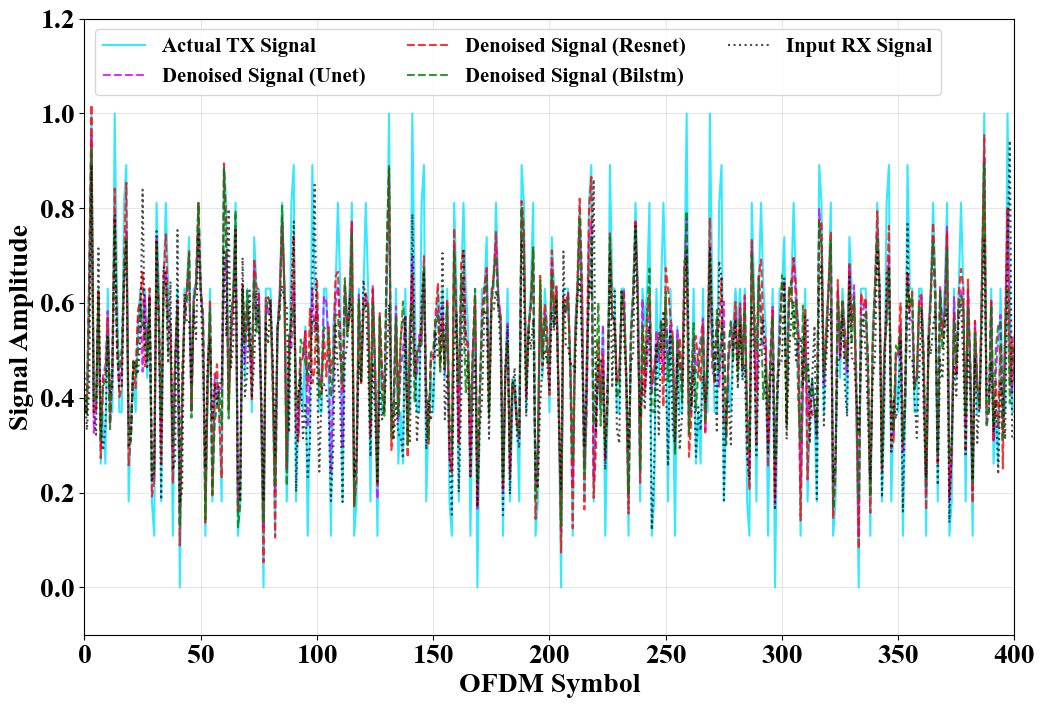

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Indices of the rows to merge
rows = list(range(210, 270)) 

plt.figure(figsize=(12, 8))
model_colors = {
    'Unet': '#CF00FF',
    # 'Bigru': 'red',
    'Resnet': 'red',
    'Bilstm': 'green'
}
# Merge and plot the actual TX signal (ground truth)
if test_tx_scaled is not None:
    merged_tx_actual = np.hstack([test_tx_scaled[row].flatten() for row in rows])
    plt.plot(merged_tx_actual, label='Actual TX Signal', linestyle='-', linewidth=1.5, alpha=0.8, color = '#00E3FF')

# Merge and plot the predicted TX signals from each model
for model_name, prediction in predictions.items():
    color = model_colors.get(model_name, 'black')
    if len(prediction.shape) > 2:
        merged_prediction = np.hstack([prediction[row].flatten() for row in rows])
    else:
        merged_prediction = np.hstack([prediction[row] for row in rows])
    
    plt.plot(merged_prediction, label=f'Denoised Signal ({model_name})', linestyle='--', alpha=0.8, color=color)

# Optionally merge and plot the input RX signal for reference
if test_rx_scaled is not None:
    merged_rx = np.hstack([test_rx_scaled[row].flatten() if len(test_rx_scaled.shape) > 2 else test_rx_scaled[row] for row in rows])
    plt.plot(merged_rx, label='Input RX Signal', linestyle=':', linewidth=1.5, alpha=0.7, color='black')

# Add legend, title, and labels
plt.legend(loc= 'upper left', ncol=3,fontsize=30, prop={'family': 'Times New Roman', 'weight': 'bold','size':'15'})
plt.xlabel('OFDM Symbol',  fontsize=20, fontname="Times New Roman", fontweight='bold')
plt.ylabel('Signal Amplitude',  fontsize=20, fontname="Times New Roman", fontweight='bold')

plt.tick_params(axis="both", labelsize = 20)
plt.xticks(fontname = "Times New Roman", fontweight = "bold")
plt.yticks(fontname = "Times New Roman", fontweight = "bold")
plt.xlim(0, 400)
plt.ylim(-0.10, 1.2)  # Set y-axis limits to start from 0
plt.grid(alpha=0.3)
plt.show()


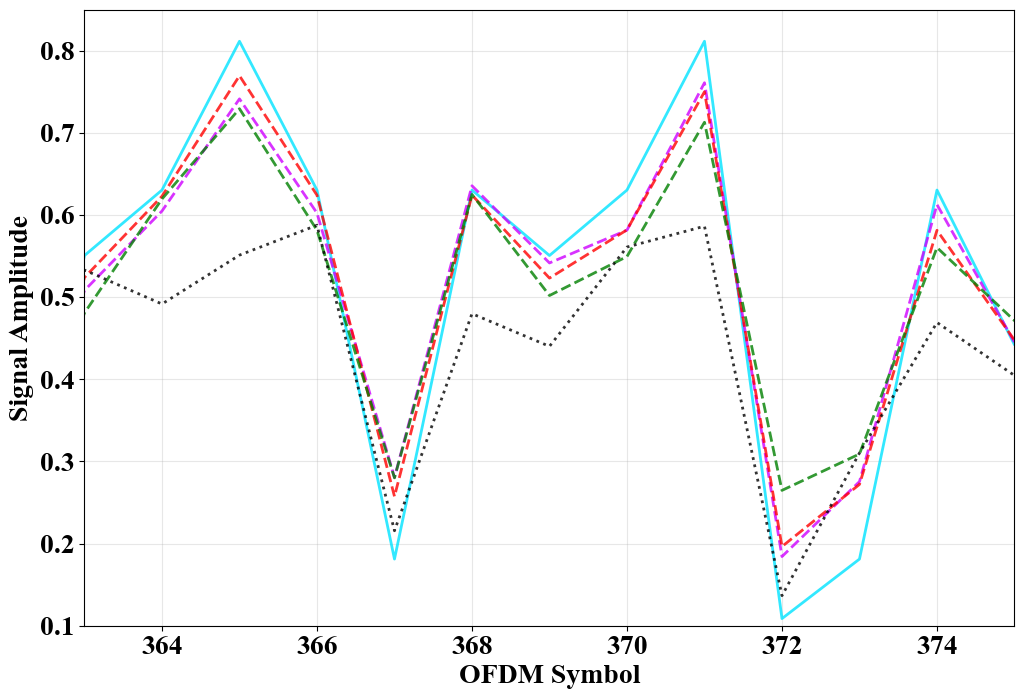

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Indices of the rows to merge
rows = list(range(210, 270)) 

plt.figure(figsize=(12, 8))

# Define colors for the models
model_colors = {
    'Unet': '#CF00FF',
    # 'Bigru': 'red',
    'Resnet': 'red',
    'Bilstm': 'green'
}

# Merge and plot the actual TX signal (ground truth)
if test_tx_scaled is not None:
    merged_tx_actual = np.hstack([test_tx_scaled[row].flatten() for row in rows])
    plt.plot(merged_tx_actual, label='Actual TX Signal', linestyle='-', linewidth=2, alpha=0.8, color='#00E3FF')

# Merge and plot the predicted TX signals from each model
for model_name, prediction in predictions.items():
    color = model_colors.get(model_name, 'black')
    if len(prediction.shape) > 2:
        merged_prediction = np.hstack([prediction[row].flatten() for row in rows])
    else:
        merged_prediction = np.hstack([prediction[row] for row in rows])
    
    plt.plot(merged_prediction, label=f'Denoised Signal ({model_name})', linestyle='--',linewidth=2, alpha=0.8, color=color)

# Optionally merge and plot the input RX signal for reference
if test_rx_scaled is not None:
    merged_rx = np.hstack([test_rx_scaled[row].flatten() if len(test_rx_scaled.shape) > 2 else test_rx_scaled[row] for row in rows])
    plt.plot(merged_rx, label='Input RX Signal', linestyle=':', linewidth=2, alpha=0.8, color='black')

# Add legend, title, and labels
# plt.legend(loc= 'upper left', ncol=3,fontsize=30, prop={'family': 'Times New Roman', 'weight': 'bold','size':'15'})
plt.xlabel('OFDM Symbol',  fontsize=20, fontname="Times New Roman", fontweight='bold')
plt.ylabel('Signal Amplitude',  fontsize=20, fontname="Times New Roman", fontweight='bold')
plt.tick_params(axis='both', labelsize=20)

plt.xticks(fontname="Times New Roman", fontweight='bold')
plt.yticks(fontname="Times New Roman", fontweight='bold')

# Ensure x-axis starts from 0
plt.xlim(363, 375)  # Set x-axis limits to start from 0 plt.xlim(363, 375)
plt.ylim(0.10, 0.85)  # Set y-axis limits to start from 0

plt.grid(alpha=0.3)
plt.show()


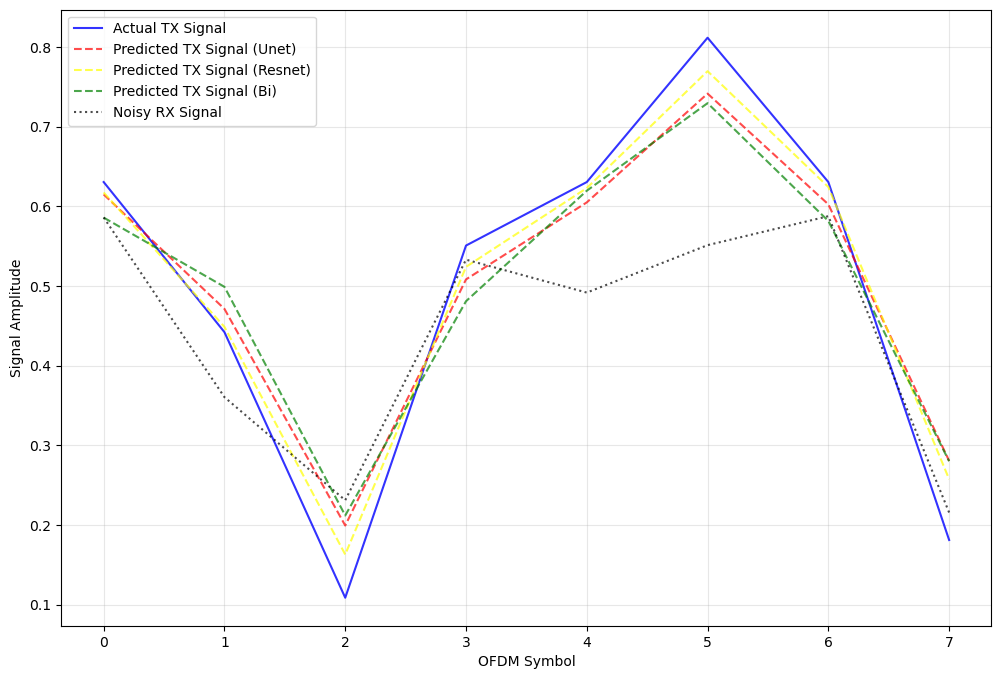

In [14]:
import matplotlib.pyplot as plt

# Define colors for the plots
actual_tx_color = 'blue'
noisy_rx_color = 'black'
model_colors = {
    'Unet': 'red',
    # 'bigru': 'red',
    'Resnet': 'yellow',
    'Bi': 'green'
}

# Plot comparison for a specific sample (e.g., idx = 0)
idx = 255  # You can change this to any index you want to compare

plt.figure(figsize=(12, 8))

# Plot the actual TX signal
plt.plot(
    test_tx_scaled[idx].flatten(),
    label='Actual TX Signal',
    linestyle='-',
    linewidth=1.5,
    alpha=0.8,
    color=actual_tx_color
)

# Plot the predicted TX signal from each model
for model_name, prediction in predictions.items():
    color = model_colors.get(model_name, 'black')  # Use the defined color or default to black
    plt.plot(
        prediction[idx].flatten(),
        label=f'Predicted TX Signal ({model_name})',
        linestyle='--',
        alpha=0.7,
        color=color
    )

# Optionally plot the input RX signal for reference
plt.plot(
    test_rx_scaled[idx].flatten(),
    label='Noisy RX Signal',
    linestyle=':',
    linewidth=1.5,
    alpha=0.7,
    color=noisy_rx_color
)

# Add legend and title
plt.legend()
plt.xlabel('OFDM Symbol')
plt.ylabel('Signal Amplitude')
plt.grid(alpha=0.3)
plt.show()
